In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve,average_precision_score,auc,roc_auc_score
import plotly.express as px
import seaborn as sns

In [184]:
# Read in the data
data = pd.read_csv('diabetes.csv')

In [185]:
# Lets have a look at the data to see what features there are
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [186]:
# We can have a look at the features to determine spread etc
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [187]:
# We look for missing data
data.isnull().sum(axis=0)

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [188]:
# We group the data by smoking history and number of people with diabetes
grouped = data.groupby(by = ['smoking_history'])['diabetes'].sum()

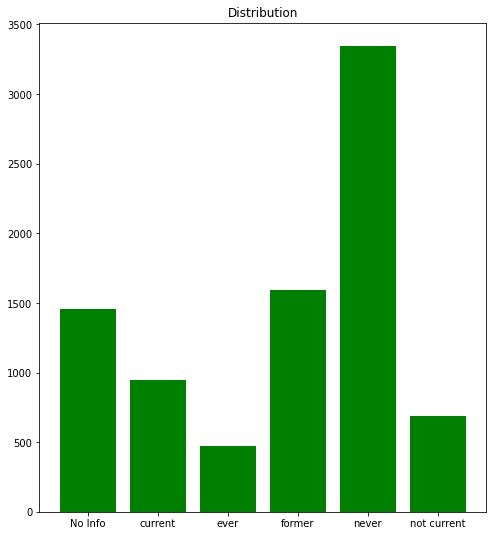

In [189]:
fig = plt.figure(figsize = (8,9))
plt.title('Distribution')
plt.bar(grouped.index,grouped, color = 'green')
plt.show()

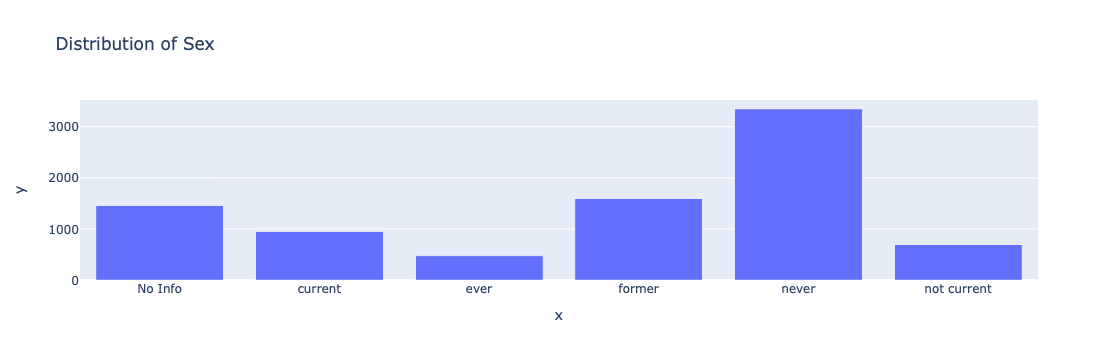

In [190]:
# Smoking history by gender
fig = px.bar(x = grouped.index,y = grouped,title="Distribution of Sex" )
fig.show()

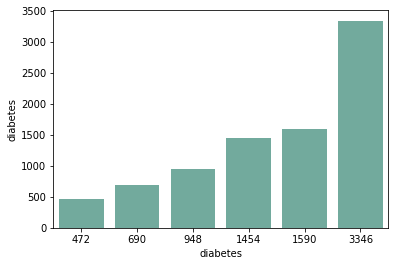

In [191]:
sns.barplot(
    y= grouped, 
    x= grouped.index, 
    data=grouped, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2');

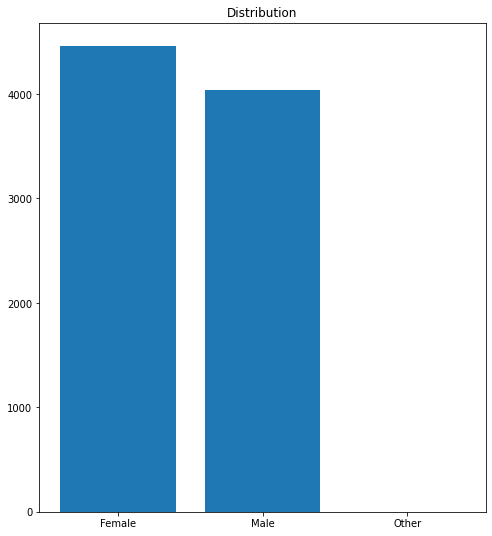

In [192]:
grouped = data.groupby(by = ['gender'])['diabetes'].sum()
fig = plt.figure(figsize = (8,9))
plt.title('Distribution')
plt.bar(grouped.index,grouped)
plt.show()

In [193]:
# We convert any categorical variables to values
data = pd.get_dummies(data, dtype=float)

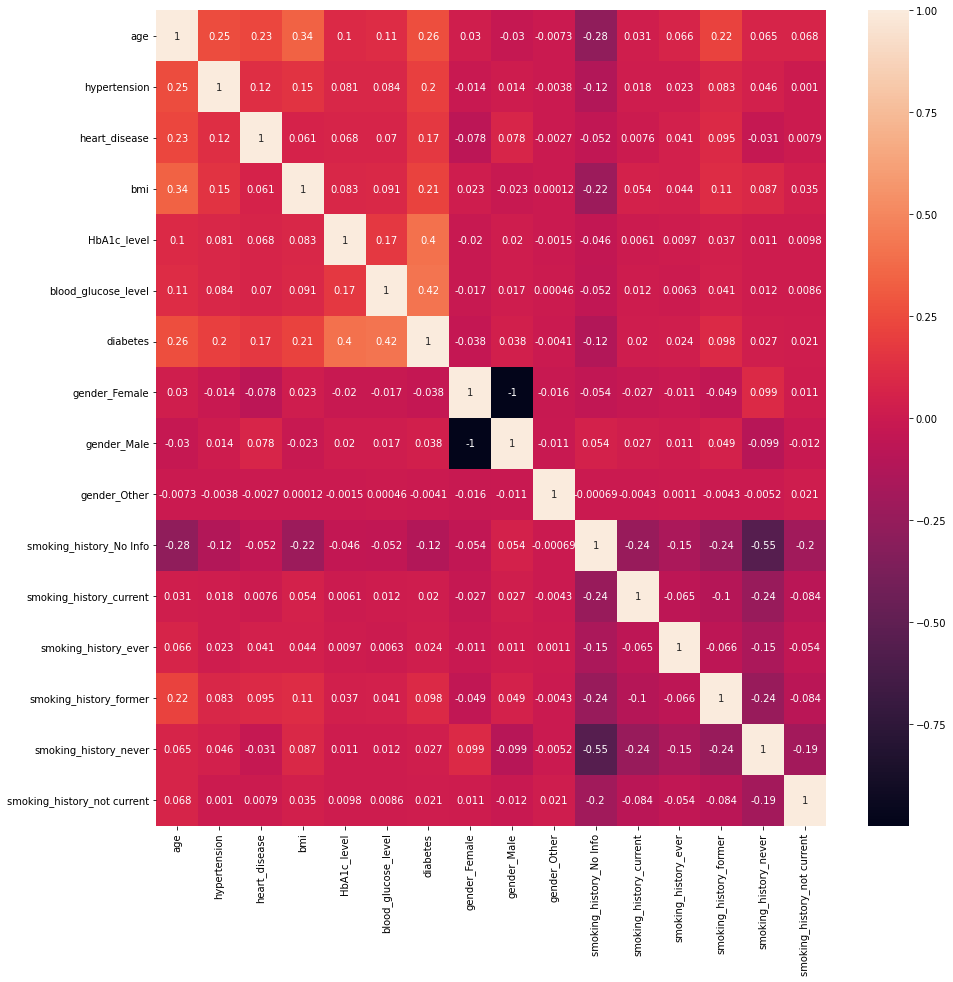

In [194]:
# We compute correlations of target variable with normal features
corr_matrix = data.corr()
fig, ax = plt.subplots(figsize=(15,15)) 
sn.heatmap(corr_matrix, annot=True,ax = ax)
plt.show()

In [195]:
# We drop the diabetes column and split the data
X = data.drop("diabetes", axis=1) # Independent variables
y = data.diabetes # Dependent variable

In [196]:
# We split the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [197]:
# We train a randomforest classifier on the training set. 
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

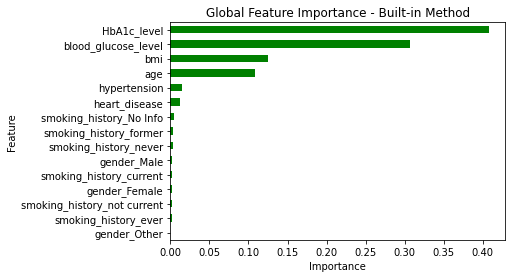

In [198]:
# We look at the most important features
global_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

In [199]:
# Remove the poor attributes
X_removed = data[['HbA1c_level','blood_glucose_level','bmi','age','hypertension','diabetes']]

In [200]:
X_t = X_removed.drop("diabetes", axis=1)
y_t = X_removed.diabetes

In [201]:
# We split the data, get some hyperpara
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.3, random_state=1)

In [202]:
hyperparameters = { 'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestclassifier__max_depth': [None, 5, 3, 1]}


In [203]:
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestClassifier(n_estimators=500))

In [204]:
clf = GridSearchCV(pipeline, hyperparameters, cv=3)

In [205]:
clf.fit(X_train, y_train)
clf.best_params_

/Users/thomasrowe/.local/share/virtualenvs/Dev-fNV4jyM8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

/Users/thomasrowe/.local/share/virtualenvs/Dev-fNV4jyM8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

/Users/thomasrowe/.local/share/virtualenvs/Dev-fNV4jyM8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pa

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__max_features': 'auto'}

In [206]:
best_rand = clf.best_estimator_
print ('AUC achieved using the best params achieved in Randomized search : ',round(roc_auc_score(y_test,best_rand.predict_proba(X_test)[:,1]),3))

AUC achieved using the best params achieved in Randomized search :  0.965
